# __Starbucks Capstone Challenge:__

__Combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type__


---
# __Business Understanding__

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers. Once every few days, Starbucks sends out an offer to users of the mobile app. 

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. Only the amounts of each transaction or offer are recorded.

There are three types of offers that can be sent: 
 1. __buy-one-get-one (BOGO)__: In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount
 2. __discount__: In a discount, a user gains a reward equal to a fraction of the amount spent.
 3. __informational__: In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend.
 
Some users might not receive any offer during certain weeks, and not all users receive the same offer, and that is the challenge to solve with this data set.

Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.

The goal is to combine transaction, demographic and offer data to: 
> __determine which demographic groups respond best to which offer type__


___
__Table of Contents:__

[1. Data exploration and cleaning](#1.-Data-exploration-and-Cleaning)

[APPENDIX - Cluster Analysis](#APPENDIX---unsupervised-Cluster-Analysis)

---
# __Data Understanding__

In [69]:
%reset -f
# %load_ext autoreload
# %autoreload 2

# must be called before importing matplotlib!!!
# %matplotlib widget

In [70]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import dataframe_image as dfi

sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rc('axes', labelsize=16)

> __load [cleaned data](#clean)__

> __to go directly to [ANALYSIS](#load)__

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploring `profile`

`profile.json` : Rewards program users (17000 users x 5 fields)
- gender: (categorical) M, F, O, or null
- age: (numeric) missing value encoded as 118
- id: (string/hash)
- became_member_on: (date) format YYYYMMDD
- income: (numeric)

In [ ]:
profile.info()

In [ ]:
profile.head()

## Exploring `portfolio`

`portfolio.json`: Offers sent during 30-day test period (10 offers x 6 fields)
- reward: (numeric) money awarded for the amount spent
- channels: (list) web, email, mobile, social
- difficulty: (numeric) money required to be spent to receive reward
- duration: (numeric) time for offer to be open, in days
- offer_type: (string) bogo, discount, informational
- id: (string/hash)

In [ ]:
portfolio.info()

Every offer has a validity period before the offer expires:
- As an example, a `bogo` offer might be valid for only 5 days or 7 days. 
- `informational` offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

In [ ]:
portfolio

## Exploring `transcript`

Transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

`transcript.json`: Event log (306648 events x 4 fields)
- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
    - offer id: (string/hash) not associated with any "transaction"
    - amount: (numeric) money spent in "transaction"
    - reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

In [ ]:
transcript.info()

In [ ]:
transcript.head()

In [ ]:
event_type = transcript['event'].unique()
print(f'we found {len(event_type)} types of offers:\n')
for evt in event_type:
    print(f'\t"{evt}"')

---
# __Data Preparation__

> All the steps taken in this section are implemented in the `lib.load_data()`

> __load [cleaned data](#clean)__

> __to go directly to [ANALYSIS](#2.-Data-Analysis)__

## Preparing `profile` 
fitering out participants with missing values:
 - missing `age` = 118
 - missing `income` = NaN
 - missing `gender` = None

In [4]:
profile = profile.query('age != 118')
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

> by filtering out the `age` we removed all missing values 

In [5]:
# we will be using id as the index 
profile.set_index('id', inplace=True)

# change `became_member_on` to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# count number of unique users
n_users = profile.index.unique().__len__()
print(f'We found {n_users} unique participants in the profile dataset')

We found 14825 unique participants in the profile dataset


In [6]:
profile.head()

,gender,age,became_member_on,income
id,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0
e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0
389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0
2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0


## Preparing `portfolio`

In [7]:
# we will be using id as the index 
portfolio.set_index('id', inplace=True)

In [8]:
# Creating code for each offer
portfolio['code'] = portfolio.apply(lambda x: x['offer_type'][0].capitalize()+'.'+str(x['duration']).zfill(2) +'.'+str(x['difficulty']).zfill(2), axis=1)
portfolio.sort_values(by=['offer_type', 'difficulty', 'duration'])

,reward,channels,difficulty,duration,offer_type,code
id,,,,,,
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,B.05.05
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,B.07.05
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,B.05.10
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,B.07.10
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount,D.07.07
2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,D.07.10
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,D.10.10
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,D.10.20
5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational,I.03.00


In [9]:
# create dummy varibale per channels
channels = pd.DataFrame(index=portfolio.index)

for col in ['web', 'email', 'mobile', 'social']:
    channels[col] = portfolio['channels'].apply(lambda x: int(col in x))

channels

,web,email,mobile,social
id,,,,
ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
3f207df678b143eea3cee63160fa8bed,1,1,1,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1


In [10]:
portfolio = portfolio.drop('channels', axis=1).join(channels.drop('email', axis=1))

## Preparing `transcript`

### Fitering out `transcript` according to the participants available in the `profile` dataset

In [11]:
user_list = list(profile.index)
transcript = transcript.query('person in @user_list')
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [12]:
n_users_trans = transcript.person.unique().__len__()
print(f'We found {n_users_trans} unique participants in the transcript dataset')

We found 14825 unique participants in the transcript dataset


### Filtering out participants that did not receive any offer

Since we will look at the offer received to measure the impact of each other we will check if all participants received at least 1 offer.

In [14]:
user_received = transcript.query('event == "offer received"')['person'].unique()
no_offer_list = list(set(profile.index).difference(set(user_received))) # TO BE REMOVED
print(f'{len(no_offer_list)} participants did not received any offer')
transcript.query('person in @no_offer_list')

5 participants did not received any offer


,person,event,value,time
16379,eb540099db834cf59001f83a4561aef3,transaction,{'amount': 4.74},6
22092,12ede229379747bd8d74ccdc20097ca3,transaction,{'amount': 16.62},18
69477,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,{'amount': 0.65},174
87239,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,{'amount': 1.9100000000000001},222
106812,ae8111e7e8cd4b60a8d35c42c1110555,transaction,{'amount': 17.51},306
108268,eb540099db834cf59001f83a4561aef3,transaction,{'amount': 5.09},318
109340,3a4874d8f0ef42b9a1b72294902afea9,transaction,{'amount': 22.75},324
109815,12ede229379747bd8d74ccdc20097ca3,transaction,{'amount': 27.6},324
110707,ae8111e7e8cd4b60a8d35c42c1110555,transaction,{'amount': 28.7},330
142347,3a4874d8f0ef42b9a1b72294902afea9,transaction,{'amount': 27.2},378


### Filtering out participants with no transactions

Since we will measure the impact of each other with the transactions that occured we will check if all participants achieve at least 1 transaction.

In [15]:
user_transactions = transcript.query('event == "transaction"')['person'].unique()
no_transaction_list = list(set(profile.index).difference(set(user_transactions))) # TO BE REMOVED
print(f'{len(no_transaction_list)} participants did not make any transactions')
transcript.query('person in @no_transaction_list')

333 participants did not make any transactions


,person,event,value,time
60,13b7b2eccf664a329d83d2a238a9a11d,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
85,d41fa9b8c2e24a1d94caa890c53bbcf6,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
141,accec36a10704e1fbaeb9b28b8bc5da8,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
155,688e4f2487d44ad8bbcc0f96936f42d6,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
160,4e5923e5deab4d5cb1624a0b1cc9909c,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
...,...,...,...,...
302780,17360c8e66a840fb82441f6c0eb8bf47,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},696
303730,e9980e136f9e4f00a2e2c895907b0d82,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},702
304010,456f5d7fe4f14732b01a85b3a584ab82,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},702
304457,1aa4e69892454c308421ad7dacac366a,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},708


### Removing participants with no `offer received` or no `transactions` made

In [16]:
participant_filter = list(set(no_offer_list + no_transaction_list))
transcript = transcript.query('person not in @participant_filter')

In [17]:
user_profile = set(profile.index)
user_received = set(transcript.query('event == "offer received"')['person'])
user_trans = set(transcript.query('event == "transaction"')['person'])

# user_list = list(user_received.intersection(user_trans).intersection(user_profile))
user_profile.intersection_update(user_received, user_trans)
len(user_profile)

14487

### Extracting data from the `value` dictionary and split it into `amount`, `offer_id`, and `reward`

In [18]:
def expand_trasncript(transcript):
    
    #change 'offer id' in 'offer_id'
    value = transcript['value'].\
        apply(lambda x:{('offer_id' if k=='offer id' else k): v for k, v in x.items()})
    
    #expand dictionary into 3 columns and add to transcript
    n_trans = transcript.join(pd.json_normalize(value))
    
    return n_trans.drop(columns=['value']) # drop obsolete columns

n_trans = expand_trasncript(transcript)
n_trans.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


---
# __Data Analysis & Modeling__

In order to analyze the data we created to classes (see `lib.starbucks_class`):
- `Person`: participant object:
    - attributes: 
        - `_id`: participant id as found in TRANSCRIPT (`person`) and PROFILE (`id`)
        - `data`: all data contain in TRANSCRIPT
        - `offers`: offers ids from received offers
        - `total_spending`: cumulative sum of all transactions
    - methods: `get_transaction()` and `get_reward()` to collect all transactions or reward between 2 timestamps.


- `Event`: object for received offer:
    - attributes:
        - `_id`: index of the received offer in TRANSCRIPT
        - `offer_id`: offer id as found in PROFILE
        - `details`: all details of the specific offer id as found in PROFILE (duration, difficulty, ...)
        - `offer_type`: offer type (bogo, discount, or informational)
        - `start`: time (in hours) where the offer was received
        - `end`: time (in hours) where the offer is supposed to end (based on offer duration)
        - `events`: subset of TRANSCRIPT from start to end
        - `viewed`: timestamp (hours) if this offer was viewed, np.nan if not
        - `completed`: timestamp (hours) if this offer was completed, np.nan if not

<a name='clean'></a>

In [15]:
import numpy as np
import pandas as pd
from lib.starbucks_class import Person, Event, PORTFOLIO, PROFILE, TRANSCRIPT

/Users/sebastienvillard/Documents/Perso/2020_DataScience_Class/Udacity_nanoDegree/Projects/Project4_CapstoneProject/lib/data_wrangling.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PROFILE['became_member_on'] = pd.to_datetime(PROFILE.loc[:,'became_member_on'], format='%Y%m%d')


## Data Analysis

### Visualizing the time-line of events for one individual

In [14]:
# gathering information from a participant included in TRANSCRIPT
user_list = TRANSCRIPT.person.unique()
user_id = user_list[5]
User = Person(user_id)
User.data

,person,event,time,offer_id,amount,reward
5,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
44475,31dda685af34476cad5bc968bdb01c53,offer viewed,150,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
46972,31dda685af34476cad5bc968bdb01c53,offer received,168,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
57733,31dda685af34476cad5bc968bdb01c53,offer viewed,168,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
84856,31dda685af34476cad5bc968bdb01c53,transaction,258,NaN,24.87,NaN
84857,31dda685af34476cad5bc968bdb01c53,offer completed,258,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
90493,31dda685af34476cad5bc968bdb01c53,transaction,288,NaN,16.26,NaN
93431,31dda685af34476cad5bc968bdb01c53,transaction,306,NaN,15.80,NaN
97797,31dda685af34476cad5bc968bdb01c53,offer received,336,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
108633,31dda685af34476cad5bc968bdb01c53,offer viewed,336,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN


In [5]:
# gathering information about a received offer from User
Offer = Event(User.offers[0], User.data)
Offer.events

,person,event,time,offer_id,amount,reward
5,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
44475,31dda685af34476cad5bc968bdb01c53,offer viewed,150,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
46972,31dda685af34476cad5bc968bdb01c53,offer received,168,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
57733,31dda685af34476cad5bc968bdb01c53,offer viewed,168,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN


In [16]:
from lib.data_visualization import time_line

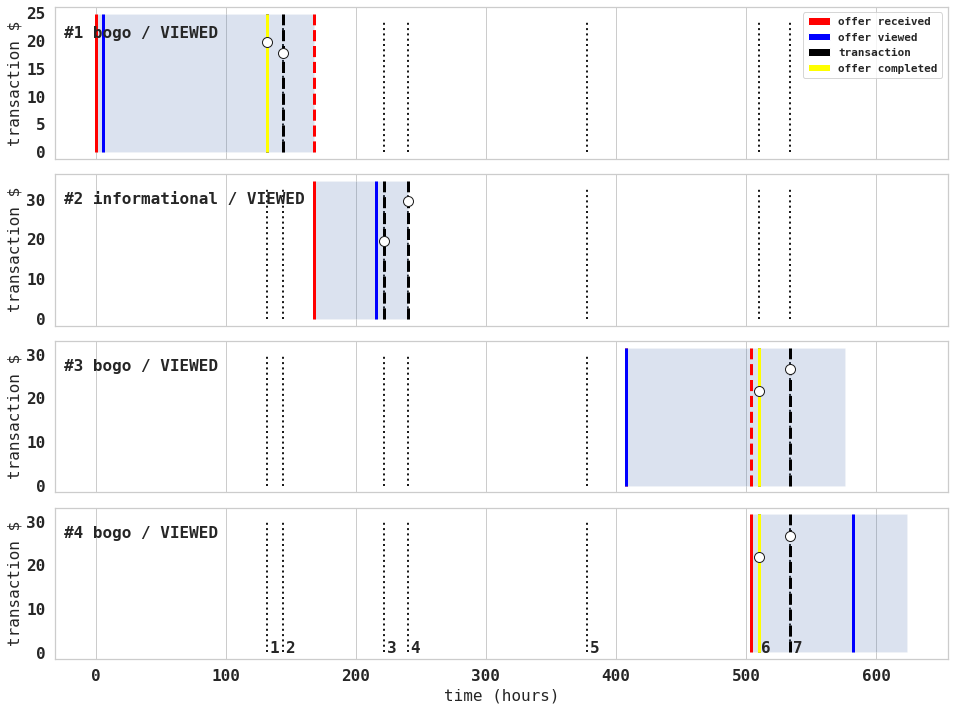

In [33]:
if True:
    User = Person('78afa995795e4d85b5d9ceeca43f5fef')
    Offer = Event(User.offers[0], User.data)

f, ax = plt.subplots(len(User.offers),1, sharex=True, figsize=[16,12])
plt.subplots_adjust(hspace=0.1)
plt.rc('axes', labelsize=16)
cnt=0

all_trans = User.get_transaction(0, User.data['time'].values[-1])

for idx in User.offers:
    plt.sca(ax[cnt])
    legend = True if cnt == 0 else False
    xlabel = True if cnt == len(ax)-1 else False
    Offer = Event(idx, User.data)
    trans = User.get_transaction(Offer.start, Offer.end)
    time_line(Offer, trans, legend=legend, xlabel=xlabel, text='#'+str(cnt+1)+' ')
        
    cnt +=1
    
for ax_n in ax:
    ymax = ax_n.get_ylim()[1]*.9
    ax_n.vlines(
        x=all_trans.time, 
        ymax=ymax, ymin=0, 
        color='k', 
        linestyle='dotted', 
        lw=2,
        zorder=0
    )
    for label in (ax_n.get_xticklabels() + ax_n.get_yticklabels()):
        label.set_fontsize(16)

offset=2
for n, x in enumerate(all_trans.time):
    ax[-1].text(
        x+offset, 0.01,
        str(n+1),
        weight='bold',
        ha='left'
    )


plt.show()

if False:
    f.savefig('./assets/Timeline.png', dpi=300)

This visualization represents all the events that occured over 30 days (720 hours) of data collection for one participant. 

Each row represents an offer received by this individual. The light blue block represents the duration of the offer. In this example, the participants received 4 offers: 3 `bogo` and 1 `informational`.

For each offer, 4 different events are marked:
 - offer received (red): When an offer was received. 
 - offer viewed (blue): When an offer is viewed
 - transacton (black): When a transaction is made
 - offer completed (yellow): When an offer is completed

The 7 transactions for this individual are shown accross the offers as black dotted lines. The transactions are not specific to an offer, and a difficulty of this analysis was to assign transactions to specific offers.
 
Few considerations:
> offer can overlap each other: the offer #4 starts during offer #3. In this situation the transaction 6 and 7 could be assigned to both offer #3 and offer #4.

> in this example, all offers have been viewed. This is not always the case. Moreover, transactions can be made before the offer is viewed (see transactions 6 and 7 for offer #4)

> transactions can be made before, during, or after an offer. We can find transactions between 2 offers (see transaction 5)

> not all offer types are presented to all participants. This will lead to differences in overall number of offers in each category.

> the number of offers presented to an individual is not always 4 (see further analysis for details).

We decided to assign a transaction to an offer (marked with white dot) if:
 - the transaction was made during the duration of the offer
 - the transaction was made after the offer was viewed
 


### Creating metrics for analysis

___
DEPENDENT VARIABLE

- What determine the best response to an offer ?
- What is a sign of Engagement ?
- Effect on transactions ?

(TO BE EDITED)

1. For an offer to have a real impact on a participant, the offer must be viewed. We will then consider the total amount of transaction for each offer received after the offer is viewed: $Trans_{viewed}$

2. Since the number of offer ($n$) and the type of offer is different for each participants, the total spending ($Spending_{tot}$) cannot be a reliable factor as is! We will compute a theoretical neutral spending amount per offer for each participants: 
    
    $Spending_{avg} = \frac{Spending_{tot}}{n}$

3. We will consider the impact of each offer recieved as the ratio:

    $Trans_{ratio} = \frac{Trans_{viewed}}{Spending_{avg}}$

This ratio will consider how a transaction performs against other offers for an individual but also against transactions outside of the viewing period. If we consider an invidual that would spend a lot outside of the offer period or that woud spend without viewing an offer, this invidual would not require specific offers.

In [5]:
import numpy as np
import pandas as pd
from lib.starbucks_class import Person, Event, PORTFOLIO, PROFILE, TRANSCRIPT

In [21]:
result = []

for user_id in set(TRANSCRIPT[:1].person):
    User = Person(user_id)
    PROFILE.loc[User._id,'total_spending'] = User.total_spending
    PROFILE.loc[User._id,'total_offers'] = len(User.offers)
    
    for _id in User.offers:
        evt = Event(_id, User.data)    
        trans = User.get_transaction(evt.viewed, evt.end) # transcations after offer is viewed
        trans_all = User.get_transaction(evt.start, evt.end) # all trasnsactions
        reward = User.get_reward(evt.viewed, evt.end) # reward after offer is viewed
        reward_all = User.get_reward(evt.start, evt.end) # all reward
        
        # results
        res_trans = np.sum(trans.amount) if len(trans) > 0 else 0 # total spent when offer viewed
        res_trans_avg = (res_trans / (min(evt.end, 720)-evt.viewed))*24 # spending per day once offer viewed
        
        res_reward = np.sum(reward.reward) if len(reward) > 0 else 0
        res_trans_all = np.sum(trans_all.amount) if len(trans_all) > 0 else 0
        res_reward_all = np.sum(reward_all.reward) if len(reward_all) > 0 else 0
        
        res_tag_viewed = 1 if evt.viewed else 0 # tag offer viewed
        res_tag_completed = 1 if evt.completed >= evt.viewed else 0 # tag offer completed after viewed
        
        result.append([
            user_id,
            PORTFOLIO.loc[evt.offer_id,'code'],
            evt.offer_type,
            res_trans_all,
            res_trans,
            res_trans_avg,
            res_reward_all,
            res_reward,
            res_tag_viewed,
            res_tag_completed
        ])

# results
RES = pd.DataFrame(result, columns=[
    'profile_id', 
    'portfolio_code',
    'portfolio_type',
    'amount_received',
    'amount_viewed',
    'amount_viewed_avg',
    'reward_received',
    'reward_viewed',
    'view_tag',
    'complete_tag'
])



In [22]:
RES

,profile_id,portfolio_code,portfolio_type,amount_received,amount_viewed,amount_viewed_avg,reward_received,reward_viewed,view_tag,complete_tag
0,78afa995795e4d85b5d9ceeca43f5fef,B.07.05,bogo,37.67,37.67,5.580741,5.0,5.0,1,1
1,78afa995795e4d85b5d9ceeca43f5fef,I.03.00,informational,49.39,49.39,49.390000,0.0,0.0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,B.07.10,bogo,48.28,48.28,6.897143,15.0,15.0,1,1
3,78afa995795e4d85b5d9ceeca43f5fef,B.05.05,bogo,48.28,0.00,0.000000,15.0,0.0,1,0


In [24]:
PORTFOLIO

,reward,difficulty,duration,offer_type,code,chann_web,chann_mobile,chann_social
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,B.07.10,0,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,B.05.10,1,1,1
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,I.04.00,1,1,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,B.07.05,1,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,D.10.20,1,0,0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,D.07.07,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,D.10.10,1,1,1
5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,I.03.00,0,1,1
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,B.05.05,1,1,1


---
SAVE RESULTS & UPDATED PROFILE

In [11]:
# save results and modified PROFILE to avoid running the analysis
from sqlalchemy import create_engine
    
if True:
    database_filename = './data/db_results.db'
    engine = create_engine('sqlite:///'+database_filename)
    RES.to_sql('Variables', engine, if_exists='replace', index=False)
    PROFILE.to_sql('Profile', con=engine, index=True, index_label='id', if_exists='replace')

___
<a name="load"></a>LOADING RESULTS

[back to import](#2.-Data-Understanding)

In [71]:
from sqlalchemy import create_engine

database_filename = './data/db_results.db'
engine = create_engine('sqlite:///'+database_filename)

RES = pd.read_sql_table('Variables', con=engine)
PROFILE = pd.read_sql_table('Profile', con=engine, index_col='id', parse_dates=['became_member_on'])

---
TARGET & FEATURES

TARGETS:
 - respondent (who's viewing the offers)
 - conversion (who's completing the offers)

In [31]:
RES.head()

,profile_id,portfolio_code,portfolio_type,amount_received,amount_viewed,reward_received,reward_viewed,view_tag,complete_tag
0,13bbddb500e54ab392c8da22ae7a41cd,D.07.10,discount,40.38,40.38,2.0,2.0,1,1
1,13bbddb500e54ab392c8da22ae7a41cd,D.10.10,discount,75.31,58.36,12.0,10.0,1,0
2,13bbddb500e54ab392c8da22ae7a41cd,B.07.10,bogo,54.04,0.00,20.0,0.0,1,0
3,13bbddb500e54ab392c8da22ae7a41cd,B.05.10,bogo,40.02,10.44,10.0,0.0,1,0
4,0d15aeb66e044f26b1a50c678cef7fe4,B.05.05,bogo,0.00,0.00,0.0,0.0,0,0


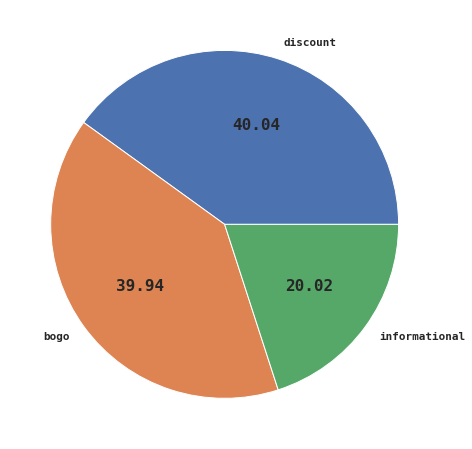

In [50]:
pie_type = RES['portfolio_type'].value_counts(normalize=True)
f,ax=plt.subplots(figsize=[16,8])
plt.pie(
    pie_type,
    labels=pie_type.index,
    autopct='%.2f'
)
plt.show

if False:
    # check DFI in import
    pie_type.to_frame().style.format("{:.2%}").export_png('./docs/assets/offer_dist.png')

### Who is responding to the offers?

In this section we will look who is viewing which offers. We are trying to identify first if we can identify a population that does not respond to all or some specific offers. 

In [20]:
# grouping the results by participants and computing viewing rate per offer type
y_view = RES.groupby(['profile_id', 'portfolio_code'])['view_tag'].mean().unstack()
y_view.head()

portfolio_code,B.05.05,B.05.10,B.07.05,B.07.10,D.07.07,D.07.10,D.10.10,D.10.20,I.03.00,I.04.00
profile_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0
0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0
0020c2b971eb4e9188eac86d93036a77,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN
0020ccbbb6d84e358d3414a3ff76cffd,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0


In [21]:
# missing data rate per offer type
y_view.isna().mean()

portfolio_code
B.05.05    0.633050
B.05.10    0.627321
B.07.05    0.625802
B.07.10    0.624077
D.07.07    0.627252
D.07.10    0.631601
D.10.10    0.626424
D.10.20    0.623732
I.03.00    0.626631
I.04.00    0.627528
dtype: float64

> The quasi-equality of the rate of missing data ($\approx 63\%$) is probably a sign of the fact that this dataset is simulated

In [22]:
# average viewing rate per offer type
y_view.mean()

portfolio_code
B.05.05    0.960224
B.05.10    0.959344
B.07.05    0.986857
B.07.10    0.973421
D.07.07    0.964074
D.07.10    0.986712
D.10.10    0.954669
D.10.20    0.994955
I.03.00    0.969649
I.04.00    0.987120
dtype: float64

> Overall, each offer presents the same rate of response: $\approx 97\%$ of each offer type is viewed

Text(0.5, 0, 'viewing rate')

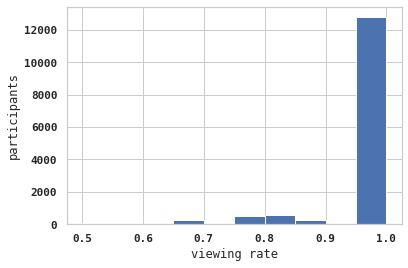

In [55]:
# histogram of 
y_view.mean(axis=1).hist()
plt.ylabel('participants')
plt.xlabel('viewing rate')

In [56]:
y_view.mean(axis=1).value_counts(normalize=True).sort_index()

0.500000    0.003797
0.666667    0.017395
0.750000    0.034031
0.800000    0.023331
0.833333    0.001104
0.833333    0.015462
0.875000    0.014427
0.888889    0.002347
0.900000    0.004211
0.916667    0.002071
1.000000    0.881825
dtype: float64

> $88\%$ of the participants viewed all the offers presented to them, and over $99\%$ viewed over $66\%$ of the offers presented. 

>All customers viewed at least $50\%$ of the offers presented to them 

> we conclude that we do not have a response problem with any offer type


### __Who is converting which offer?__

Looking at the offer completed after being viewed, I computed the average completion rate per offer type (more than one offer type could be presnted to each customer)

In [95]:
# average completion (after being viewed) per offer type
# we computed the average since more than one offer of each lind can have be  presented
y_complete = RES.groupby(['profile_id', 'portfolio_type'])['complete_tag'].mean().unstack()
y_complete.head()

portfolio_type,bogo,discount,informational
profile_id,,,
0009655768c64bdeb2e877511632db8f,0.0,0.000000,0.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.000000,0.0
0020c2b971eb4e9188eac86d93036a77,0.5,0.500000,0.0
0020ccbbb6d84e358d3414a3ff76cffd,1.0,1.000000,0.0
003d66b6608740288d6cc97a6903f4f0,NaN,0.666667,0.0


In [73]:
# conversion rate
y_complete.mean()

portfolio_type
bogo             0.414981
discount         0.461080
informational    0.000000
dtype: float64

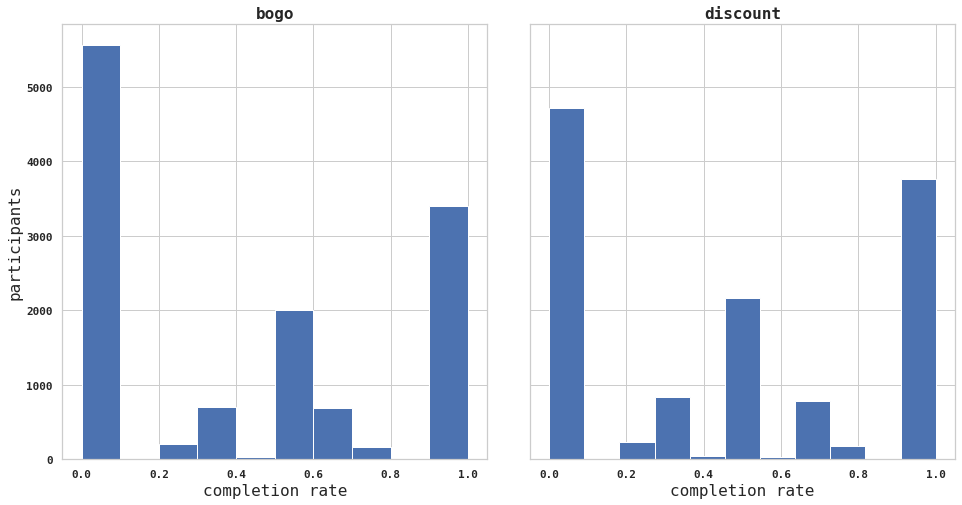

In [100]:
f,ax =plt.subplots(1,2,sharey=True, figsize=[16,8])
plt.subplots_adjust(wspace=.1)

y_complete['bogo'].hist(ax=ax[0])
y_complete['discount'].hist(ax=ax[1], bins=11)

ax[0].set_ylabel('participants')
ax[0].set_xlabel('completion rate')
ax[0].set_title('bogo', weight='bold', fontsize=16)

ax[1].set_xlabel('completion rate')
ax[1].set_title('discount', weight='bold', fontsize=16)
plt.show()

> For the rest of this analysis we will consider sucess as completion rate of $50\%$ and higher

In [102]:
y_complete = y_complete.applymap(lambda x: int(False) if x < 0.5 else (int(True) if x==x else None))

---
JOINING FEATURES AND TARGETS

In [103]:
X = PROFILE.loc[y_complete.index,:]
X.head()

,gender,age,became_member_on,income,total_spending,total_offers
profile_id,,,,,,
0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,127.60,5.0
0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000.0,79.46,5.0
0020c2b971eb4e9188eac86d93036a77,F,59,2016-03-04,90000.0,196.86,5.0
0020ccbbb6d84e358d3414a3ff76cffd,F,24,2016-11-11,60000.0,154.05,4.0
003d66b6608740288d6cc97a6903f4f0,F,26,2017-06-21,73000.0,48.34,5.0


In [104]:
df = X.join(y_complete.drop('informational', axis=1))
df.gender = df.gender.astype('category')
df.head()

,gender,age,became_member_on,income,total_spending,total_offers,bogo,discount
profile_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,127.60,5.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000.0,79.46,5.0,1.0,1.0
0020c2b971eb4e9188eac86d93036a77,F,59,2016-03-04,90000.0,196.86,5.0,1.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,F,24,2016-11-11,60000.0,154.05,4.0,1.0,1.0
003d66b6608740288d6cc97a6903f4f0,F,26,2017-06-21,73000.0,48.34,5.0,NaN,1.0


---
CORRELATION MATRIX

In [105]:
df.corr().style.background_gradient(cmap='Blues').format("{:.2f}")

,age,income,total_spending,total_offers,bogo,discount
age,1.00,0.31,0.11,-0.01,0.10,0.06
income,0.31,1.00,0.33,-0.01,0.22,0.13
total_spending,0.11,0.33,1.00,0.09,0.37,0.27
total_offers,-0.01,-0.01,0.09,1.00,0.00,-0.02
bogo,0.10,0.22,0.37,0.00,1.00,0.22
discount,0.06,0.13,0.27,-0.02,0.22,1.00


We originally recorded the number of offers and the total spending because we thought that the former might influence the later. Yet, these 2 variables show very weak correlation coefficient ($r=0.09$).

However, the `total_spending` shows the highest correlation coefficient with the completion of the `bogo` and `discount` offers.

---
$INCOME = f(AGE)$

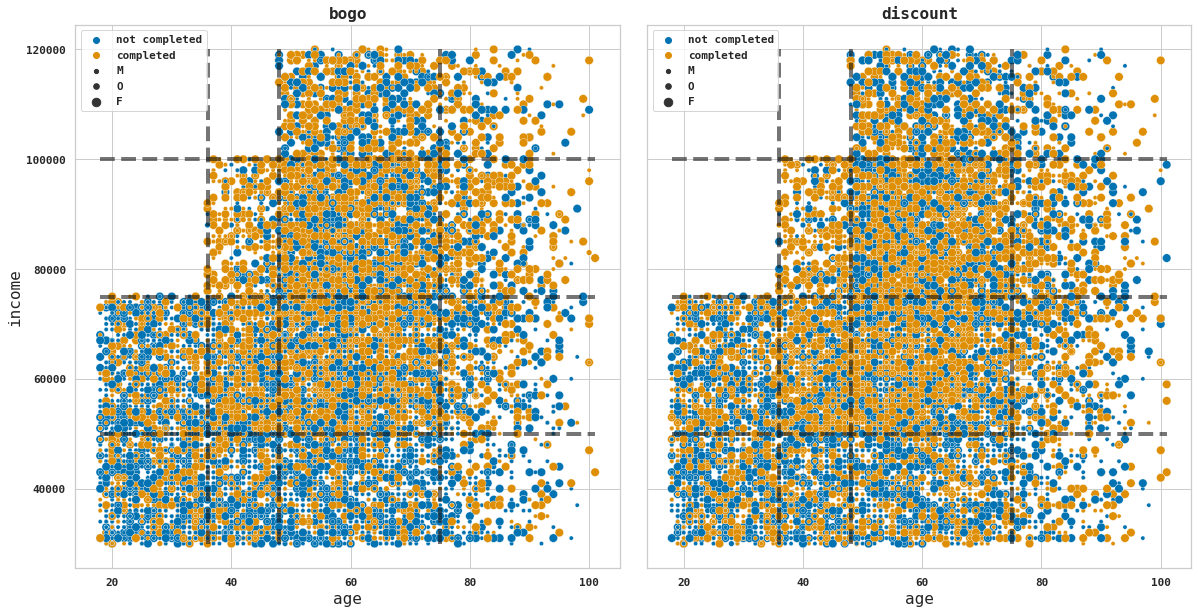

In [107]:
size_dict = {
    'M':1,
    'O':2,
    'F':5
}

mkr_dict = {
    'M':"o",
    'O':"d",
    'F':"v"
}

size = [size_dict[k] for k in df.gender]
mkr = [mkr_dict[k] for k in df.gender]

offer=['bogo', 'discount']
labels = ['not completed', 'completed', 'M', 'O', 'F']

f, ax = plt.subplots(1,2, figsize=[20,10], sharey=True)
age_breaks = [36, 48, 75]
inc_breaks = [50000, 75000 ,100000]

plt.subplots_adjust(wspace=.05)

for i, col in enumerate(offer):
    sns.scatterplot(data=df, x='age', y='income', hue=col, ax=ax[i], palette='colorblind', size=size)
    ax[i].vlines(
        x=age_breaks,
        ymin=df.income.min(),
        ymax=df.income.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    ax[i].hlines(
        y=inc_breaks,
        xmin=df.age.min(),
        xmax=df.age.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    handles, _ = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, labels)
    ax[i].set_title(col, weight='bold', fontsize=16)
    
if True:
    f.savefig('./docs/assets/AgeIcome.png', dpi=150, transparent=True)

From this represntation we can clearly identify 2 income breaks at 75k, and 100k. From both the `bogo` and the `discount` offers `completed` groups we can identify a $3^{rd}$ income break at 50k. We will therefore split the income in 4 brackets:

1. 30k - 50k,
2. 50k - 75k,
3. 75k - 100k
4. \> 100k

Accordingly, we can identify ages brackets:

1. \< 36,
2. 36 - 48,
3. 48 - 75: (this last age break could be adjusted up to 80 yo)

---
$AGE = f(MEMBERSHIP)$

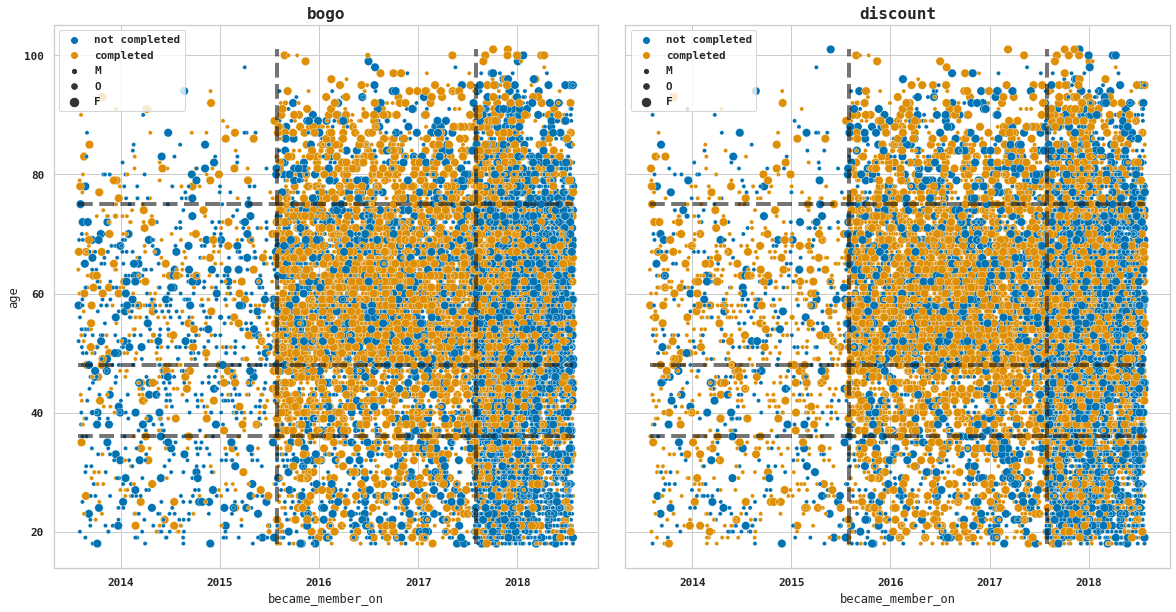

In [13]:
from datetime import datetime

date_breaks = [
    datetime(year=2015, month=8, day=1),
    datetime(year=2017, month=8, day=1)
]

f, ax = plt.subplots(1,2, figsize=[20,10], sharey=True)
plt.subplots_adjust(wspace=.05)

for i, col in enumerate(offer):
    sns.scatterplot(data=df, x='became_member_on', y='age', hue=col, ax=ax[i], palette='colorblind', size=size)
    ax[i].vlines(
        x=date_breaks, 
        ymin=df.age.min(), 
        ymax=df.age.max(), 
        ls='dashed', 
        color='k', 
        lw=4,
        alpha=0.6
    )
    ax[i].hlines(
        y=age_breaks,
        xmin=df.became_member_on.min(),
        xmax=df.became_member_on.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    handles, _ = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, labels)
    ax[i].set_title(col, weight='bold', fontsize=16)

In [ ]:
f.savefig()

This representation shows 3 clear periods:
 1. start - August 2015
 2. August 2015 - August 2017
 3. August 2017 - end
 
It looks like a lot of women of all ages becoming member during the period 2 are very likely to complete the `bogo` and the `discount` offers. 

---
$INCOME = f(MEMBERSHIP)$

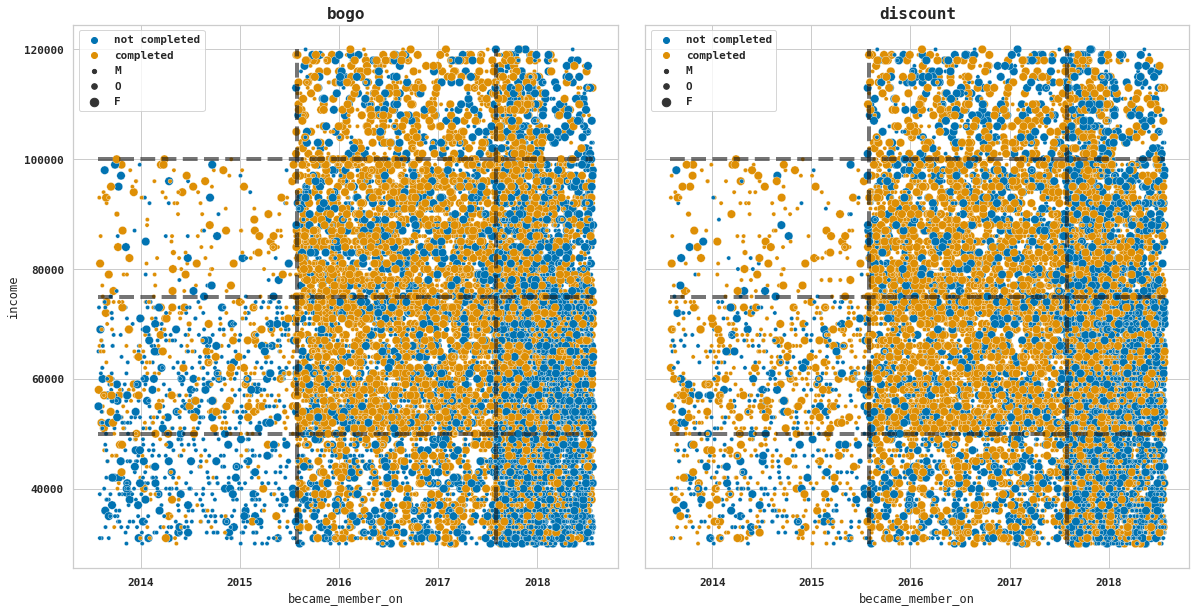

In [14]:
f, ax = plt.subplots(1,2, figsize=[20,10], sharey=True)
plt.subplots_adjust(wspace=.05)

for i, col in enumerate(offer):
    sns.scatterplot(data=df, x='became_member_on', y='income', hue=col, ax=ax[i], palette='colorblind', size=size)
    ax[i].vlines(
        x=date_breaks,
        ymin=df.income.min(),
        ymax=df.income.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    ax[i].hlines(
        y=inc_breaks,
        xmin=df.became_member_on.min(),
        xmax=df.became_member_on.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    handles, _ = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, labels)
    ax[i].set_title(col, weight='bold', fontsize=16)

In [8]:
from lib.data_wrangling import create_features

In [9]:
feat = create_features(X)
feat

,age_brackets,membership,income_brackets,gender
profile_id,,,,
0009655768c64bdeb2e877511632db8f,<36,to 2017-08-01,50k-74k,M
0011e0d4e6b944f998e987f904e8c1e5,36-47,to 2018-07-26,50k-74k,O
0020c2b971eb4e9188eac86d93036a77,48-74,to 2017-08-01,75k-99k,F
0020ccbbb6d84e358d3414a3ff76cffd,<36,to 2017-08-01,50k-74k,F
003d66b6608740288d6cc97a6903f4f0,<36,to 2017-08-01,50k-74k,F
...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,48-74,to 2017-08-01,75k-99k,F
fff7576017104bcc8677a8d63322b5e1,48-74,to 2018-07-26,50k-74k,M
fff8957ea8b240a6b5e634b6ee8eafcf,48-74,to 2018-07-26,50k-74k,M


In [36]:
df_feat = feat.join(y_complete)
df_feat.head()

,age_brackets,membership,income_brackets,gender,bogo,discount,informational
profile_id,,,,,,,
0009655768c64bdeb2e877511632db8f,<36,to 2017-08-01,50k-74k,M,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,36-47,to 2018-07-26,50k-74k,O,1.0,1.0,0.0
0020c2b971eb4e9188eac86d93036a77,48-74,to 2017-08-01,75k-99k,F,1.0,1.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,<36,to 2017-08-01,50k-74k,F,1.0,1.0,0.0
003d66b6608740288d6cc97a6903f4f0,<36,to 2017-08-01,50k-74k,F,NaN,1.0,0.0


___
DESCRIPTIVE STATISTICS

In [42]:
df_feat = df_feat.join(df.total_spending)

In [48]:
df_feat.groupby(['age_brackets', 'membership', 'income_brackets', 'gender']).agg({
    'bogo':'size',
    'total_spending': 'sum'
})

bogo  total_spending
age_brackets membership    income_brackets gender                      
<36          to 2015-08-01 <50k            F         26         1162.71
                                           M        111         6091.33
                                           O          1           39.49
                           50k-74k         F         32         1834.93
                                           M        115         7130.51
...                                                 ...             ...
>75          to 2018-07-26 75k-99k         M         85        12564.45
                                           O          3          479.55
                           >100k           F         62         9761.93
                                           M         22         2998.71
                                           O          0            0.00

[144 rows x 2 columns]

In [32]:
res_bogo = df_feat.groupby(['age_brackets', 'membership', 'income_brackets', 'gender'])['bogo']\
    .value_counts(normalize=True)\
    .unstack()

res_bogo = res_bogo.reset_index()
res_bogo.sort_values(by=1, ascending=False)[:25].style.bar(color='#53bce6')

bogo,age_brackets,membership,income_brackets,gender,0.0,1.0
61,48-74,to 2015-08-01,75k-99k,O,nan,1.000000
5,<36,to 2015-08-01,50k-74k,O,nan,1.000000
40,36-47,to 2017-08-01,>100k,F,nan,1.000000
9,<36,to 2017-08-01,<50k,O,nan,1.000000
63,48-74,to 2015-08-01,>100k,M,nan,1.000000
42,36-47,to 2017-08-01,>100k,O,nan,1.000000
52,36-47,to 2018-07-26,>100k,F,nan,1.000000
33,36-47,to 2017-08-01,<50k,O,nan,1.000000
75,48-74,to 2017-08-01,>100k,O,nan,1.000000
72,48-74,to 2017-08-01,75k-99k,O,0.058824,0.941176


In [33]:
res_discount = df_feat.groupby(['age_brackets', 'membership', 'income_brackets', 'gender'])['discount']\
    .value_counts(normalize=True)\
    .unstack()

res_discount = res_discount.reset_index()
res_discount.sort_values(by=1, ascending=False)[:50].style.bar(color='#53bce6')

discount,age_brackets,membership,income_brackets,gender,0.0,1.0
40,36-47,to 2017-08-01,>100k,M,nan,1.000000
61,48-74,to 2015-08-01,75k-99k,O,nan,1.000000
35,36-47,to 2017-08-01,50k-74k,O,nan,1.000000
32,36-47,to 2017-08-01,<50k,O,nan,1.000000
41,36-47,to 2017-08-01,>100k,O,nan,1.000000
100,>75,to 2017-08-01,75k-99k,O,nan,1.000000
51,36-47,to 2018-07-26,>100k,F,nan,1.000000
39,36-47,to 2017-08-01,>100k,F,nan,1.000000
55,48-74,to 2015-08-01,<50k,O,nan,1.000000
13,<36,to 2017-08-01,75k-99k,M,nan,1.000000


In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from lib.data_wrangling import find_best_offer

In [23]:
age = 43
member = '2017-09-01'
income = 63000
gender = 'M'
df_offer= res_discount

find_best_offer(age, member, income, gender, df_offer)

discount,age_brackets,membership,income_brackets,gender,0.0,1.0
46,36-47,to 2018-07-26,50k-74k,M,0.016094,0.010127


In [261]:
res_bogo

bogo,age_brackets,membership,income_brackets,gender,0.0,1.0
0,<36,to 2015-08-01,<50k,F,0.001450,0.000207
1,<36,to 2015-08-01,<50k,M,0.005108,0.001519
2,<36,to 2015-08-01,<50k,O,0.000069,NaN
3,<36,to 2015-08-01,50k-74k,F,0.001104,0.000897
4,<36,to 2015-08-01,50k-74k,M,0.004349,0.002278
...,...,...,...,...,...,...
109,>75,to 2018-07-26,75k-99k,F,0.003106,0.004625
110,>75,to 2018-07-26,75k-99k,M,0.002278,0.002623
111,>75,to 2018-07-26,75k-99k,O,0.000069,0.000138
112,>75,to 2018-07-26,>100k,F,0.001795,0.002209


___
SCALING DATA

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
dropcols=['gender', 'became_member_on']
X_filt = X.drop(dropcols, axis=1)

scalerY = RobustScaler(quantile_range=(25.0, 75.0))
Y_sc = scalerY.fit_transform(Y)

scalerX = RobustScaler(quantile_range=(25.0, 75.0))
X_sc = scalerX.fit_transform(X_filt)

dfY = pd.DataFrame(Y_sc, columns=Y.columns, index=Y.index)
dfX = pd.DataFrame(X_sc, columns=X_filt.columns, index=X_filt.index)

In [ ]:
df = pd.concat([X_filt, Y['spending_ratio_discount']],axis=1)
corr_matrix = df.corr(method="pearson")

f, ax =plt.subplots(1,1, figsize=[10,8])
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

# __5. Model Evaluation & Results__

___
LINEAR MODEL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

In [ ]:
col = Y.columns.tolist().index('amount_viewed_bogo')
mask = np.isnan(Y_sc[:,col])

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(scalerX.inverse_transform(X_sc)[~mask,:], scalerY.inverse_transform(Y_sc)[~mask,col], test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(X_sc[~mask,:], Y_sc[~mask,col], test_size=.2)
feature_names = X_filt.columns.tolist()
feature_names

In [ ]:
model = GradientBoostingRegressor()

In [ ]:
# model.fit(X_train, y_train)
model.fit(X_sc[~mask,:], Y_sc[~mask,col])
importances = model.feature_importances_

prediction = model.predict(X_test)
score = r2_score(y_test, prediction)
score

In [ ]:
model.train_score_

In [ ]:
X_sc.shape

In [ ]:
df_importances = pd.DataFrame(
    {
        'IMPORTANCES': importances,
        'VARIABLES': feature_names
    }
)

df_importances.set_index('VARIABLES', inplace=True)

df_importances = df_importances.sort_values('IMPORTANCES', ascending=False)
df_importances['cumsum'] = df_importances['IMPORTANCES'].cumsum()

In [ ]:
f, ax = plt.subplots(1,2,figsize=[10,8])

df_importances['IMPORTANCES'].sort_values().plot(kind='barh', ax=ax[0])
ax[0].set_ylabel("")

df_importances['cumsum'].plot(kind='line', marker='o',ax=ax[1])
plt.xticks(rotation='vertical')
plt.show()

___
NONLINEAR MODEL

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(
    kernel='poly', 
    C=100, gamma='auto', 
    degree=3, 
    epsilon=.1,
    coef0=1
)

In [ ]:
preds = svr_rbf.fit(X_sc[~mask,:], Y_sc[~mask,col]).predict(X_test)


In [ ]:
score = r2_score(y_test, preds)
score

# __6. Conclusion & Deployment__

___
___
PREVOUS WORK - TO BE REVIEWED

### 1.5 Distribution of Offer type in `transcript`

In [ ]:
TRANSCRIPT =  expand_trasncript(pd.read_json('data/transcript.json', orient='records', lines=True))
offer_distribution = TRANSCRIPT.query('event == "offer received"')['offer_id'].value_counts(normalize=True)
offer_distributaion = offer_distribution.to_frame(name="received ratio")
offer_distribution['type'] = portfolio.loc[offer_distribution.index, 'offer_type']
offer_distribution.sort_values('type')

### 1.6 Analysis of events time-line

- `offer received` should trigger the offer duration (`portfolio`)
- `offer viewed` should tag this event in success metrics
- `transaction` & `reward` should build the succes metrics

In [ ]:
#reset variable
del transcript, portfolio, profile

In [ ]:
plt.rcParams['figure.figsize']=[10,10]

style_evt = {
    'offer received':'red',
    'offer viewed':'blue',
    'transaction':'black',
    'offer completed':'yellow'
}

from matplotlib.patches import Patch


legend_elements = [
    Patch(facecolor='red', label='offer received'),
    Patch(facecolor='blue', label='offer viewed'),
    Patch(facecolor='black', label='transaction'),
    Patch(facecolor='yellow', label='offer completed')
]

def time_line(event, transactions=[], legend=False):
    ax = plt.gca()
    ymax = 10
    tag = 'VIEWED' if event.viewed > 0 else 'not viewed'
    text = event.details['offer_type'].values[0] + ' / ' +tag
    evt_list = evt.events['event'].tolist()
    color_list = [style_evt[k] for k in evt_list]
    
    
    if len(transactions) > 0:
        ymax = transactions.amount.max()
        ax.plot(transactions.time, transactions.amount, 'ko')
        
    ax.vlines(x=event.events['time'], ymax=ymax, ymin=0, color=color_list)
    ax.fill_between(x=[event.start,event.end], y1=[0,0], y2=[ymax,ymax], alpha=.2)
    ax.set_title(text, ma='right')
    ax.set_xlabel('time (hours)')
    ax.set_ylabel('transaction $')
    
    if legend:
        ax.legend(handles=legend_elements, loc='best')
    
        

In [ ]:
PROFILE.total_offers.hist(bins=6)

### __Descriptive statistics__

We are using this table of descriptive statisctis to filter out the dataset to the most relevant subset of data.

In [ ]:
descriptive_stats = df.describe()
descriptive_stats

In [ ]:
subdf.describe()

To filter out outliers values we are following the traditional definition of values outside of the Inter Quartile Range. We are setting an order of priority in the filtering process:
1. `total_spending`
2. `bogo` and `discount`
3. `informational`

In order to keep the maximum amount of data we decided to stop the filtering if the number of participants decrease below 80% of the original dataset.

In [ ]:
cols = [ 'total_spending', 'bogo', 'discount', 'informational']

subdf = df.copy()

# remove low total_spending at q1
q1 = descriptive_stats['total_spending']['25%']
q3 = descriptive_stats['total_spending']['75%']
iqr = q3-q1
low = 10
up = q3 + (1.5 * iqr)
subdf = subdf.query('@low < total_spending < @up')

print(f'The new dataset has {len(subdf)} participants\n')

f, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 8))
f.suptitle("Filtered dataset", fontsize=14, fontweight='bold')
plt.subplots_adjust(wspace=0.8)
win=0
cols = ['total_spending', 'bogo', 'discount', 'informational', 'income', 'age']

for i in cols:
    sns.boxplot(data=subdf, x='gender', y=i, ax=ax[win], palette='Blues')
    if i in ['bogo', 'discount', 'informational']:
        ax[win].set_ylim(top=300)
    win += 1
    

## __REGRESSION__

 - What model?
 - Do we need categorical features?

In [ ]:
from lib.data_wrangling import create_features
features = create_features(PROFILE)
features = features.loc[subdf.index, :]
features

In [ ]:
sns.boxplot(x=features.income_brackets, y=df_ratio.bogo, palette="Blues")

 - computing spending ratio for each offer type (ratio spent after a type of offer is viewed over the total spending)

In [ ]:
df_ratio = subdf[['bogo', 'discount', 'informational']].div(subdf.total_spending, axis='rows')
df_ratio

In [ ]:
df_response = subdf[['bogo', 'discount', 'informational']].gt(subdf.offer_avg, axis='rows').astype(int)
df_response

In [ ]:
toto = subdf[['bogo', 'discount', 'informational']].median()
toto

In [ ]:
subdf['bogo'].gt(toto.bogo, axis='rows').sum()

In [ ]:
subdf = subdf.join(df_response, rsuffix='lab')

In [ ]:
sns.pairplot(subdf, hue='bogolab',corner=True)

In [ ]:
# Generate correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=10, h_pos=220, s=60,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True)

### 2.2. Offer Viewed:

In [ ]:
viewed_stack = RES.query('profile_id in @subdf.index').groupby('portfolio_type')['view_tag'].value_counts()
x_table = viewed_stack.unstack()
x_table.columns = ['not viewed', 'viewed']
x_table

In [ ]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(x_table)
print(f'the probability of the distribution to be homogeneous is p = {p:.2}')
if p < 0.5:
    print('\tWe can reject the null hypothesis')
else:
    print('\tWe cannot reject the null hypothesis')

In [ ]:
ax = x_table.subtract(expected).plot(kind='bar', y='viewed')
ax.set_title('Difference to expected in number of viewed offer')
plt.show()

> we can conclude that the type of offer impact the number of viewed offer.
It looks like `discount` and `informational` offers were more viewed that `bogo`

In [ ]:
df_X = df_ratio
cat = 'spending_brackets'
list_cat = list(features[cat].cat.categories)
col = sns.color_palette("colorblind", len(list_cat))
palette = [col[k] for k in features[cat].cat.codes]

f = plt.figure()
ax = Axes3D(f)
sc = ax.scatter3D(
    df_X.bogo,
    df_X.discount, 
    df_X.informational,
    marker='o',
    edgecolor='k',
    c=features[cat].cat.codes
)

plt.xlabel('Buy-One-Get-One')
plt.ylabel('Discount')
ax.set_zlabel('Informational')

handles, _ = sc.legend_elements()
labels = features[cat].cat.categories.tolist()
ax.legend(handles, labels)

In [ ]:
plt.figure()
pie_gender = df.gender.value_counts(normalize=True).to_frame()
pie_gender
plt.pie(
    data=pie_gender,
    x='gender',
    autopct='%.2f',
    labels=pie_gender.index,
    normalize=False
)
plt.show()

---
---
# __APPENDIX - unsupervised Cluster Analysis__
## __Clustering Analysis__

__1. K_pod method to apply kmeans to dataset with missing data__

 - (reference)
 - (explanation)

In [ ]:
from kPOD import k_pod

In [ ]:
cluster_df = df_ratio
cluster_df

In [ ]:
#set the number of clusters
k=4

# use data with missing values to perform clustering
clustered_data = k_pod(cluster_df.to_numpy(), k)

In [ ]:
cluster_labels = clustered_data[0]

In [ ]:
for offer in cluster_df:
    sns.violinplot(
        x=cluster_labels,
        y=offer,
        data=cluster_df,
        scale_hue=False
    )
    plt.ylabel(f'{offer}')
    plt.show()

__2. Tradiational Kmeans clustering by changing missing values with median__

We are replacing each missing values with the median from the related category: `bogo`, `discount`, or `informational` 

In [ ]:
# RES_median = RES_ratio.apply(lambda x: x.fillna(x.median()),axis=0)
RES_median = cluster_df.apply(lambda x: x.fillna(x.median()),axis=0)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm

range_n_clusters = list(range(2,10))

X = RES_median.to_numpy()


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 20])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    if True:
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

plt.show()

__3. Implementing silhouette analysis to k-pod__

In [ ]:
%matplotlib inline

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from kPOD import k_pod
import matplotlib.cm as cm

range_n_clusters = list(range(2,9))

X = cluster_df.copy().to_numpy()

def replace_by_centroids(data, labels, centers):
    #locate missing data
    locs = np.argwhere(np.isnan(data))
    for i in locs:
        row=i[0]
        col=i[1]
        lab = int(labels[row])
        center = centers[lab][col]
        
        data[row,col] = center
    
    return data


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 20])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = k_pod(n_clusters=n_clusters, data=X)
    cluster_labels = clusterer[0]
    centers = clusterer[1]
    
    # replace missing data with centroids
    X = replace_by_centroids(X, cluster_labels, centers)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    
    # Draw white circles at cluster centers
    centers = np.vstack(centers)
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
plt.plot(df_X['total_spending'])

### __3D Graphical representation__

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
%matplotlib auto

In [ ]:
X = cluster_df.to_numpy()
clusterer = k_pod(n_clusters=3, data=X)
cluster_labels = clusterer[0]
centers = clusterer[1]

# replace missing data with centroids
X = replace_by_centroids(X, cluster_labels, centers)

In [ ]:
col = sns.color_palette("colorblind", len(cluster_labels))
palette = [col[int(x)] for x in cluster_labels]

f = plt.figure(figsize=(6,6))
ax = Axes3D(f)
ax.scatter3D(
    cluster_df.bogo, 
    cluster_df.discount, 
    cluster_df.informational,
    marker='o',
    edgecolor='k',
    c=palette
)

plt.xlabel('Buy-One-Get-One')
plt.ylabel('Discount')
ax.set_zlabel('Informational')

In [ ]:
X[0]

## __Building ML model over multiple outputs__

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = df.bogo.dropna()
X = pd.get_dummies(features.loc[y.index,:])

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2)

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn import svm

In [ ]:
# model = SGDRegressor(loss='huber', penalty='elasticnet')
model = svm.SVR()

In [ ]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [ ]:
model.score(X_test, y_test)

In [ ]:
plt.plot(y_test, preds, 'o')

In [ ]:
df.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
coder = OneHotEncoder()
gender = coder.fit_transform(df['gender'].to_numpy().reshape(-1, 1))

In [ ]:
gender.toarray()

### PROFILE (APPENDIX)
Quick visualization of the PROFILE dataset

In [ ]:
PROFILE.head()

In [ ]:
f1, ax1 = plt.subplots(1,1, figsize=[16,8])
gender = PROFILE

f2, ax2 = plt.subplots(1,3, figsize=[16,8])
plt.subplots_adjust(wspace=0.3)


sns.violinplot(
    data=PROFILE,
    x='income',
    y='gender',
    ax=ax[0],
    inner='box',
    scale='area',
    orient='h'
)
ax2[0].set_title('Ditribution of INCOME by gender')

sns.violinplot(
    data=PROFILE,
    x='age',
    y='gender',
    ax=ax2[1],
    orient='h'
)
ax2[1].set_title('Ditribution of AGE by gender')

PROFILE.groupby('gender')['became_member_on'].value_counts().unstack(0).cumsum()[::20].plot(ax=ax[2],marker='o')
ax2[2].set_title('Cumulative Sum of MEMBERSHIP from 2014 to 2019')
plt.show()

__1. Are all offers distributed equally among `TRANSCRIPT` ?__

In [ ]:
offer_distribution = TRANSCRIPT.query('event == "offer received"')['offer_id'].value_counts(normalize=True)
offer_distribution = offer_distribution.to_frame(name="received ratio")
offer_distribution['type'] = PORTFOLIO.loc[offer_distribution.index, 'offer_type']
offer_distribution = offer_distribution.sort_values('type')
offer_distribution.style.format({'received ratio':"{:.2%}"})

To filter out outliers values we are following the traditional definition of values outside of the $1.5 * IQR$, where IQR is the distance between first and the third quartile.

(TO BE EDITED)
We are setting an order of priority in the filtering process:
1. `total_spending`
2. `bogo` and `discount`
3. `informational`

In order to keep the maximum amount of data we decided to stop the filtering if the number of participants decrease below 80% of the original dataset.

In [ ]:
cols = ['amount_received', 'amount_viewed']

subdf = RES.copy()

# remove low total_spending at q1
q1 = des_stats[cols[0]]['25%']
q3 = des_stats[cols[0]]['75%']
iqr = q3-q1
low = 10
up = q3 + (1.5 * iqr)
str_expr = f'@low < {cols[0]} < @up'
subdf = subdf.query(str_expr)

print(f'The new dataset has {len(subdf)} observations\n')

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
f.suptitle("Filtered dataset", fontsize=14, fontweight='bold')
plt.subplots_adjust(wspace=0.3)
win=0

for i in cols:
    sns.boxplot(
        data=subdf, 
        x='portfolio_type', 
        y=i, 
        ax=ax[win], 
        palette='Blues',
        hue='view_tag',
        order=['bogo', 'discount', 'informational']
    )
    win += 1
    

In [ ]:
len(RES)

___
OFFER TYPE DISTRIBUTION

In [ ]:
offer_distribution = RES['portfolio_type'].value_counts(normalize=True)
offer_distribution = offer_distribution.to_frame(name="received ratio")
offer_distribution.style.format({'received ratio':"{:.2%}"})

In [ ]:
f, ax = plt.subplots(1,1, figsize=[8,8])
pie_data = offer_distribution

plt.pie(
    data=pie_data, 
    x='received ratio', 
    labels= pie_data.index, 
    autopct='%.2f'
)
plt.title('Distribution of each offer type in transcript')
plt.show()

## 4.2. Modeling

(TO BE UPDATED)\
In order to use `PROFILE` later on as features we are going to categorize all `profile` columns:
 - `age` is being splitted into 8 age brackets
 - only the year is kept from `became_member_on`. These values are being transformed into category
 - `income` is being splitted into 8 income brackets

In [ ]:
feat_profile = pd.DataFrame()

#age brackets
'''divide age in 8 brackets'''
bins_age = [0, 25, 35, 45, 55, 65, 75, 85, 110]
lab_age = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '>85']
feat_profile['age_brackets'] = pd.cut(profile['age'], bins=bins_age, labels=lab_age, right=False)

#membership year
'''keep only the year of membership'''
feat_profile['year_member'] = profile['became_member_on'].apply(lambda x:x.year)
feat_profile['year_member'] = feat_profile['year_member'].astype('category')

#income brackets
'''divide income in 8 brackets'''
bins_income = [30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 120000]
lab_income = ['<40k', '40k-49k', '50k-59k', '60k-69k', '70k-79k', '80k-89k', '90k-99k', '>100k']
feat_profile['income_brackets'] = pd.cut(profile['income'], bins=bins_income, labels=lab_income, right=False)

feat_profile = feat_profile.join(profile['gender'])
feat_profile.head()